#Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO

#Parte 1

In [2]:
#Função para plotar sinal original, corrompido e filtrado
def graph(sn_valores, xn_valores, sinal_filtrado, a):
  plt.figure(figsize=(16,  4))
  plt.vlines(x=np.arange(200),ymin = 0 , ymax=xn_valores, color='r', alpha=0.8)
  plt.vlines(x=np.arange(200),ymin = 0 , ymax=sn_valores, color='c', alpha=1)
  plt.plot(sn_valores, 'o', label= 'Sinal Original',  color='c', markersize=3)
  plt.plot(xn_valores, 'D', label= 'Sinal Corrompido',  color='r', markersize=4)
  plt.plot(sinal_filtrado, 'o', label= 'Sinal Filtrado com a = ' + str(a),  color='g', markersize=4)
  plt.title('Sinal')
  plt.xlabel('Amostras')
  plt.ylabel('Amplitude')
  plt.grid(True)
  plt.legend()
  plt.show()

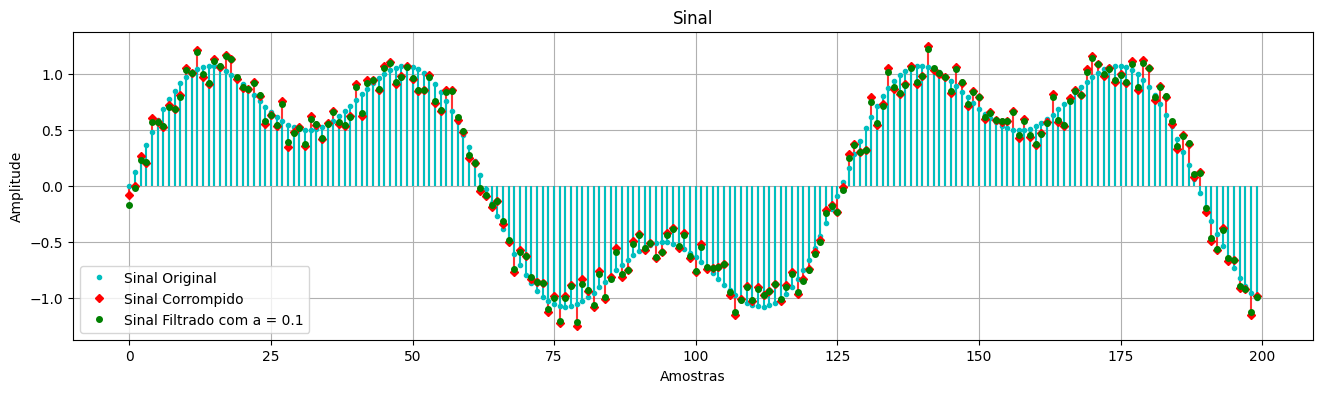

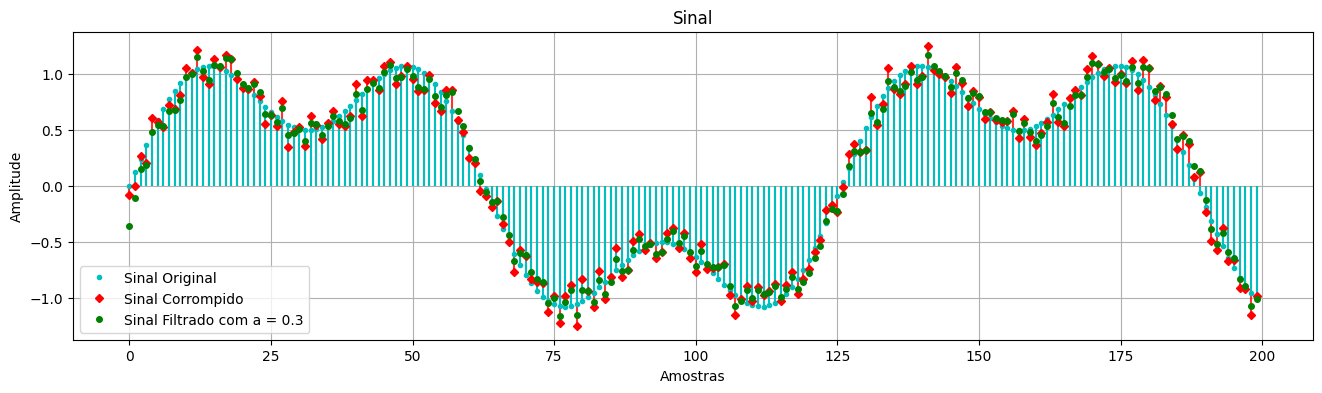

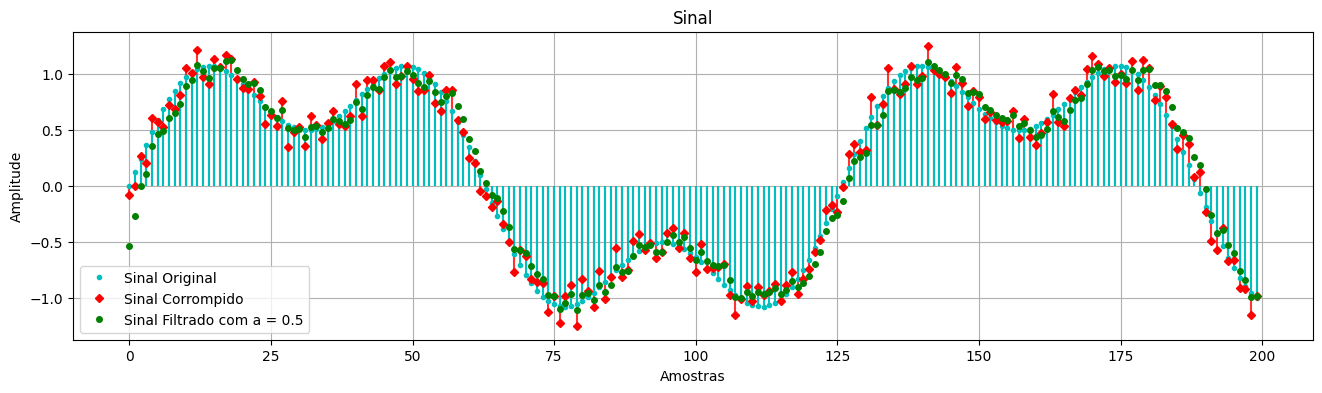

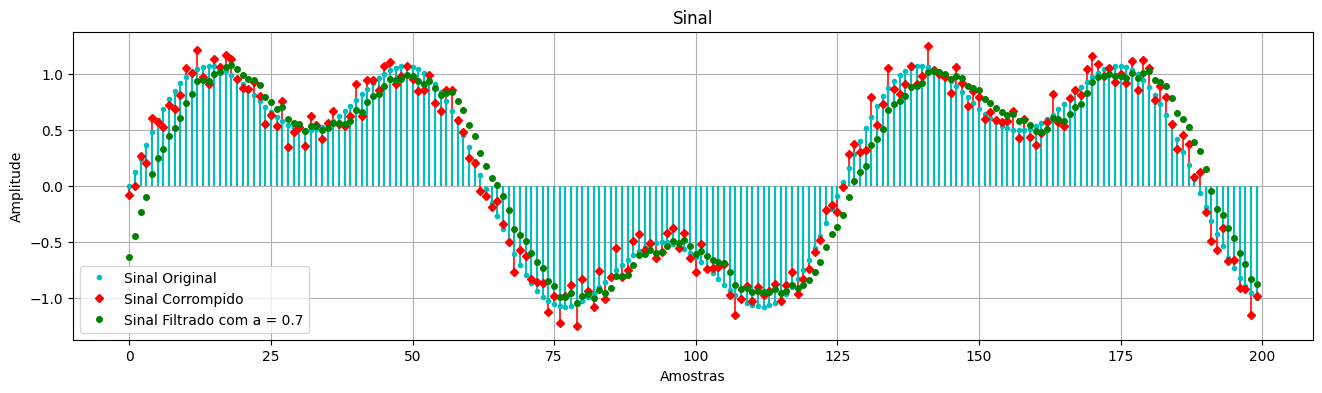

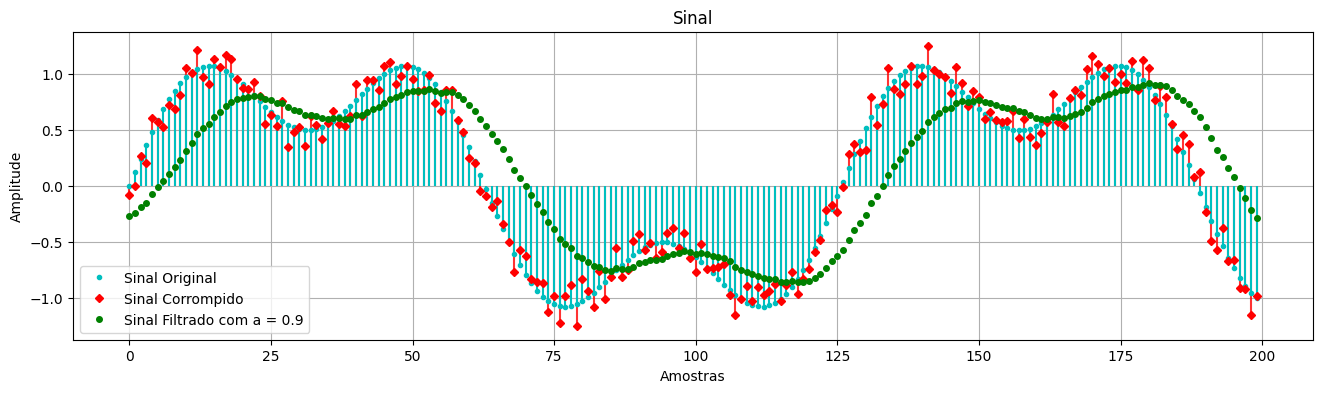

In [3]:
#Configurações gerais
qt_amostras = 200 #Quantidade de amostras
amplitude_maxima = 0.2  #Amplitude máxima do ruído
a_valores = [0.1,0.3, 0.5,0.7, 0.9]  #Valores para o parâmetro 'a'
vt_amostras = np.arange(qt_amostras) #Vetor de amostras


#Sinal original para amostras de 0 a 200
sn = lambda n: math.sin(0.05*n) + 0.5* math.sin(0.15*n)
sn_valores = [sn(valor) for valor in vt_amostras]

#Ruido para 200 amostras
ruido_valores = np.random.uniform(-amplitude_maxima, amplitude_maxima, qt_amostras)

#Sinal corrompido é a soma do orginal com o ruido
xn_valores = sn_valores + ruido_valores

#Contrução da resposta ao impulso
hn_valores = lambda n, a: (1 - a)*(a)**n

def resposta_impulso(a,vt_amostras, hn):
  return [hn(valor, a) for valor in vt_amostras]

#Convolução
def convolucao(xn,hn, qt_amostras):
    y = np.zeros(qt_amostras)
    for n in range(qt_amostras):
        for m in range(qt_amostras):
          y[n] += xn[m] * hn[n - m]
    return y[:qt_amostras]


#Sinal filtrado e plot dos gráficos para diferentes valores de 'a'
for a in a_valores:
  sinal_filtrado = convolucao(xn_valores, resposta_impulso(a,vt_amostras, hn_valores), qt_amostras)
  graph(sn_valores, xn_valores, sinal_filtrado, a)


##Comentários

Através dos gráficos é possivel ver que quanto mais próximo o valor de 'a' chega a 1, maior será a suavização do sinal de saída. Isso ocorre pois o parâmetro 'a' controla a seletividade do filtro passa-baixas. Essa seletividade é responsável por definir a frequência de corte, diminuindo o intervalo de frequências que podem "passar" pelo filtro.

Com os resultados é possível dizer que que definitivamente o valor de 0.9 para 'a' foi o qual resultou em um sinal com maior suavidade, seguindo o resultado que era esperado. Quando 'a' é 0.5 ou 0.7 já temos um sinal meio termo, levemente suavizado com pouco ruído. Já para valores menores, vemos que o sinal filtrado continua sendo afetado consideravelmente pelos ruídos.


#Parte 2

In [4]:
#filtro suavização
k_suav = np.array([[1,1,1], [1,1,1], [1,1,1]])/9
#filtro bordas
k_bordas = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])


In [5]:
def transf_img(img):
  #Transforma a imagem em cinza
  img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
  #Mostra a imagem original em cinza
  plt.imshow(img_gray, cmap=plt.get_cmap('gray'))
  plt.title('Imagem original')
  plt.show()
  return img_gray

In [6]:
def convolucao2D(image, filtro):
  f_altura = filtro.shape[0]   #Shape retorna um array com altura no indice 0 e largura no 1
  f_largura = filtro.shape[1]
  resultado = np.zeros_like(image, dtype=np.float32) #inicializa um array com zeros igual a imagem

  #Adicionar padding para evitar problemas nas bordas
  padding_y = f_altura // 2
  padding_x = f_largura // 2
  imagem_padded = np.pad(image, ((padding_y, padding_y), (padding_x, padding_x)), mode='constant', constant_values=0)

  for y in range(image.shape[0]):
    for x in range(image.shape[1]):
      #Extrair a região correspondente do filtro
      regiao = imagem_padded[y:y+f_altura, x:x+f_largura]
      #Aplicar o filtro
      valor = np.sum(regiao * filtro)
      resultado[y, x] = valor
  return resultado

#Função representativa para fazer a convolução com o filtro
def apply_filter(image, filtro):
  return convolucao2D(image, filtro)


##Primeira imagem

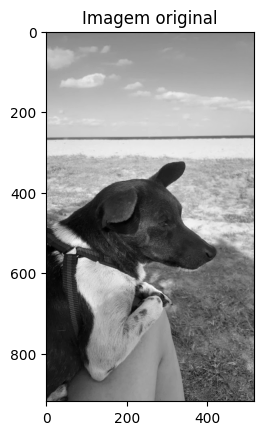

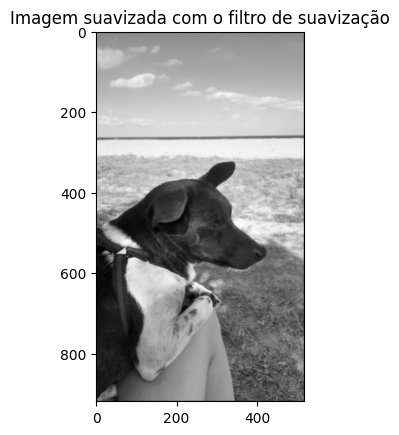

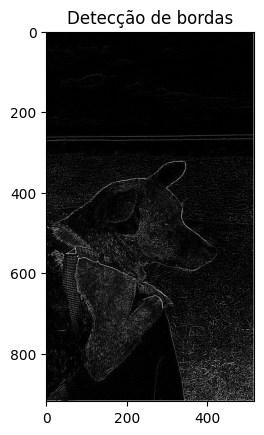

In [7]:
#URL da imagem
url = 'https://lh3.googleusercontent.com/pw/AP1GczMdlgpO8Z-gORSeBdwCgdvYhfppCVPYnwnxYP-3gah0r_6-1mno8ndTy3kqA3kV0ayUntIVtTw22cAmEgL4TGergyK463tkz7xJyh3ylYYsc_TXnpqPfc6zpTi-s7XX-cmehsxJYzvqP7sT_sbLDE1F=w517-h919-s-no'

#Parte responsável por transformar a imagem em escala cinza e plotar
img = np.array(Image.open(requests.get(url, stream=True).raw))
img_bw = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
plt.imshow(img_bw, cmap=plt.get_cmap('gray'))
plt.title('Imagem original')
plt.show()

#Aplicação do filtro de suavização
img_filtered = apply_filter(img_bw, k_suav)

#Plotando a imagem suavizada com o filtro
plt.imshow(img_filtered, cmap=plt.get_cmap('gray'))
plt.title('Imagem suavizada com o filtro de suavização')
plt.show()


#Aplicação do filtro de detecção de bordas na imagem
img_filtered = apply_filter(img_bw, k_bordas)

#Esse método faz com que valores menores que zero fiquem zero, e maiores que 255 fiquem 255
#O restante permanece igual
img_filtered = np.clip(img_filtered, 0, 255)

#Plotando a imagem com detectação de bordas
plt.imshow(img_filtered, cmap=plt.get_cmap('gray'))
plt.title('Detecção de bordas')
plt.show()

##Segunda imagem

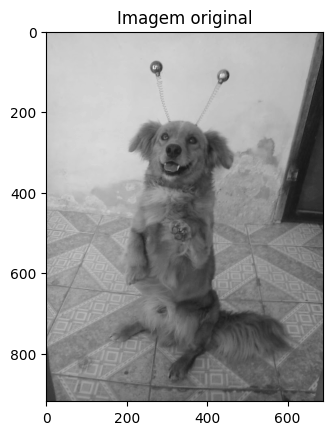

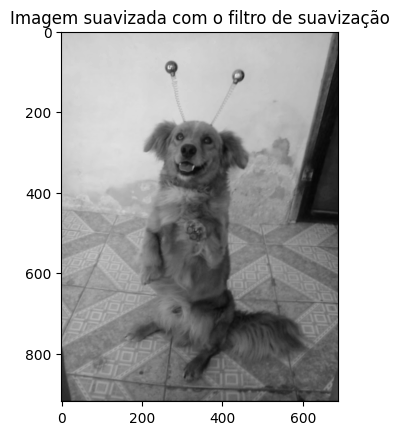

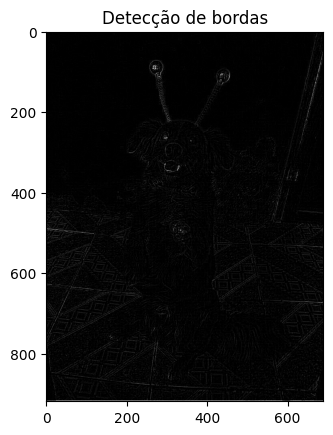

In [8]:
#URL da imagem
url2 = 'https://lh3.googleusercontent.com/pw/AP1GczOT1q81qJySacEoeGfp0OdhrTAg4e0sC5N_FAdKY21CGYY31j1vUWT81B5K3w4Jf4bZdGonzT5VMnxVAnGi27pUmCAhIxiA3TpuNDl7-Eyz_gHzf5fWAD1MI9fIFTANZbaUuDjxAcDmLPMq72u6pnFO=w689-h919-s-no'

#Parte responsável por transformar a imagem em escala cinza e plotar
img2 = np.array(Image.open(requests.get(url2, stream=True).raw))
img_bw2 = np.dot(img2[...,:3], [0.2989, 0.5870, 0.1140])
plt.imshow(img_bw2, cmap=plt.get_cmap('gray'))
plt.title('Imagem original')
plt.show()

#Aplicação do filtro de suavização
img_filtered2 = apply_filter(img_bw2, k_suav)

#Plotando a imagem suavizada com o filtro
plt.imshow(img_filtered2, cmap=plt.get_cmap('gray'))
plt.title('Imagem suavizada com o filtro de suavização')
plt.show()


#Aplicação do filtro de detecção de bordas na imagem
img_filtered2 = apply_filter(img_bw2, k_bordas)

#Esse método faz com que valores menores que zero fiquem zero, e maiores que 255 fiquem 255
#O restante permanece igual
img_filtered2 = np.clip(img_filtered2, 0, 255)

#Plotando a imagem com detectação de bordas
plt.imshow(img_filtered2, cmap=plt.get_cmap('gray'))
plt.title('Detecção de bordas')
plt.show()

##Comentários
Como podemos ver, na primeira imagem onde temos um destaque maior para as bordas foi possível evidenciar de forma mais destacada a utilização dos filtros. Já na segunda imagem, as bordas são menos aparentes, assim, o filtro não obteve muito sucesso para detectar as bordas.